In [30]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [31]:

data=pd.read_csv("./laboratory.csv")

In [32]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [33]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [34]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [35]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [36]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      co2      so2     no2    pm1  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  507.934  2216.85  21.831  6.452   
2023-04-19 11:41:03  20.790   9.040  1.730  504.029  2216.82  21.776  6.477   
2023-04-19 11:43:05  20.789  10.338  1.726  503.302  2216.73  22.191  6.661   
2023-04-19 11:45:06  20.793   9.173  1.723  503.272  2216.77  23.159  6.771   
2023-04-19 11:47:08  20.792   8.218  1.720  503.708  2216.80  24.173  5.844   

                     dewpt  tvoc      o3   sound  pm2_5  temperature  \
date                                                                   
2023-04-19 11:39:01  6.523   0.0  27.653  57.259  7.996       19.024   
2023-04-19 11:41:03  6.466   0.0  27.600  52.367  8.203       19.012   
2023-04-19 11:43:05  6.456   0.0  27.512  52.689  8.830       19.009   
2023-04-19 11:45:06  6.458   0.0  27.481  56.539  8.191       19.012   
2023-04-19 11:

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

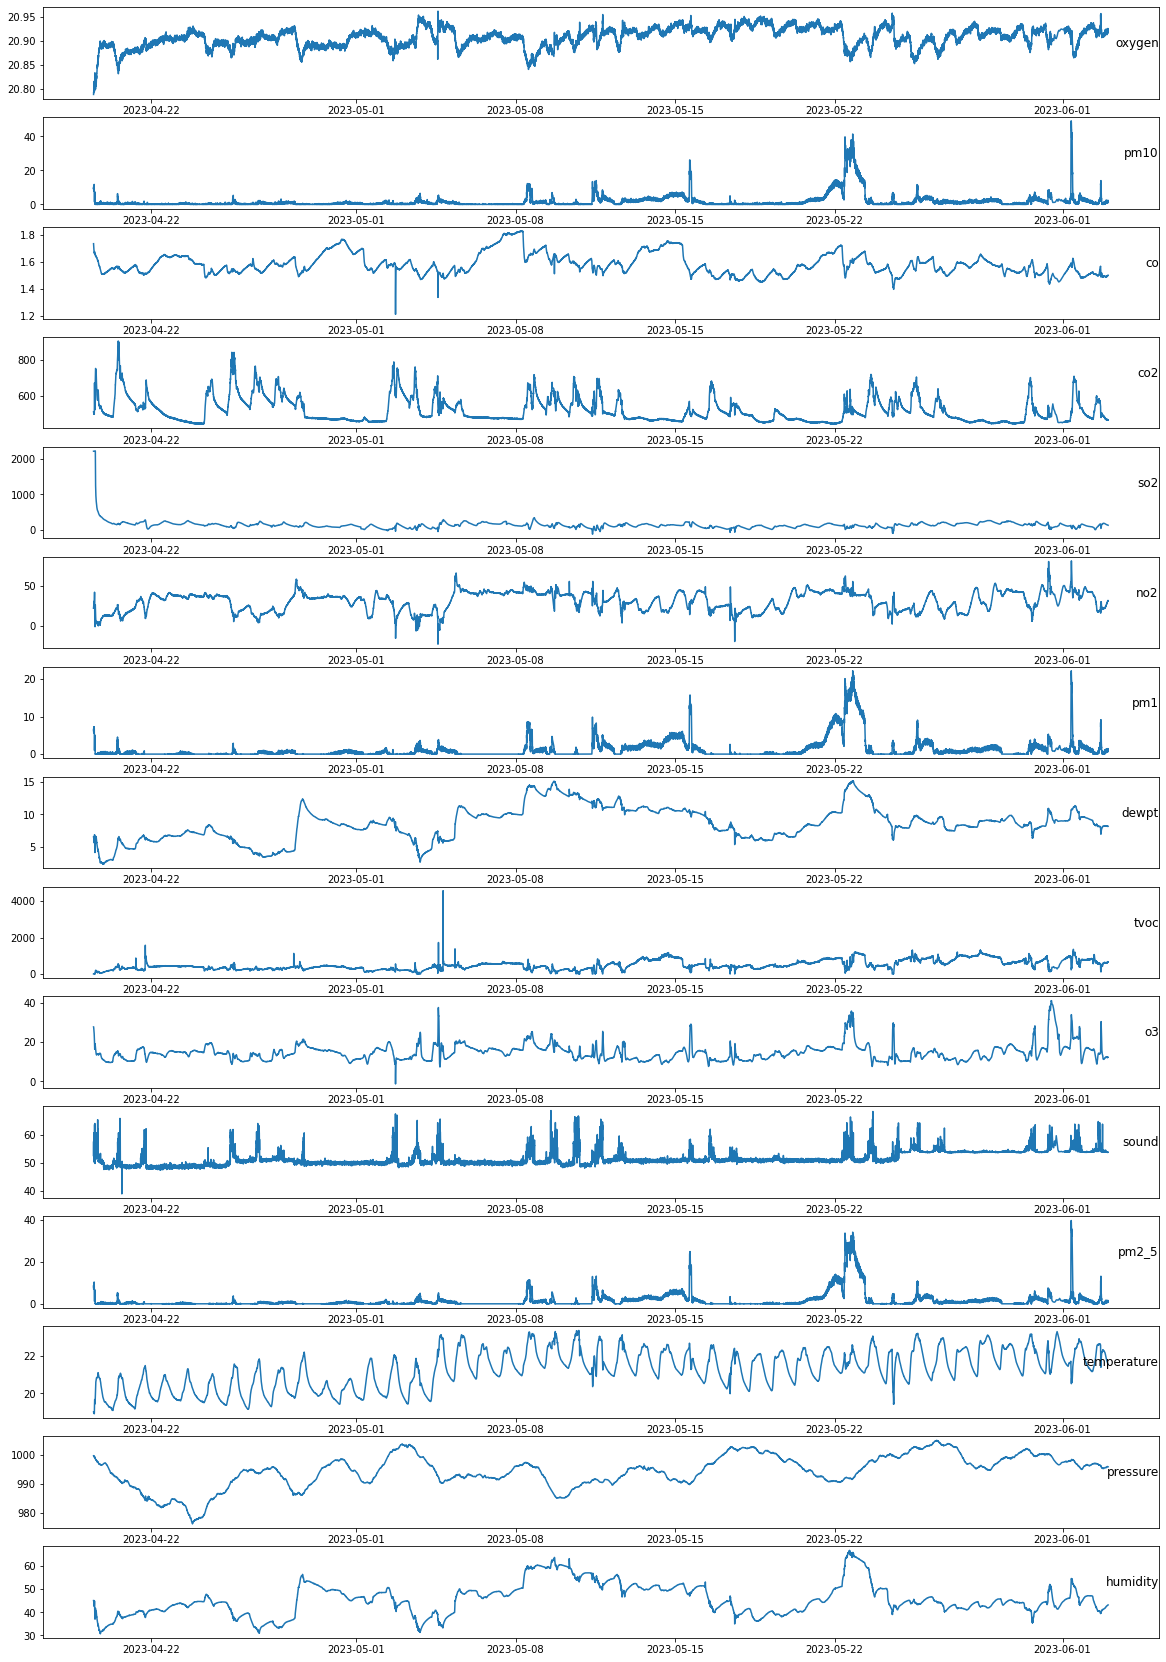

In [37]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [38]:
data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) & (data['o3']<18)
data['IAQ'] = data['IAQ'].astype(object).replace({False: 0, True: 1})
data.insert(0, 'IAQ', data.pop('IAQ'))

In [39]:
d = data.corr()
display(d)

,IAQ,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
IAQ,1.000000,-0.107925,-0.152940,-0.165913,0.230650,0.037361,-0.343932,-0.176465,-0.268769,-0.526089,-0.178189,-0.149936,-0.156487,-0.229956,-0.050069,-0.198089
oxygen,-0.107925,1.000000,-0.052039,-0.139242,-0.556470,-0.321751,-0.028337,-0.016336,-0.154200,0.175673,-0.229181,-0.079021,-0.047771,0.024722,0.102779,-0.203497
pm10,-0.152940,-0.052039,1.000000,0.097176,-0.061900,-0.022493,0.203993,0.976669,0.373451,0.234680,0.488560,0.196562,0.996691,0.167845,-0.009889,0.399391
co,-0.165913,-0.139242,0.097176,1.000000,-0.250964,0.099278,0.315492,0.155287,0.350687,0.272963,0.016380,-0.228305,0.116640,-0.013695,-0.210786,0.409289
co2,0.230650,-0.556470,-0.061900,-0.250964,1.000000,0.024084,-0.347952,-0.095813,-0.102401,-0.294373,-0.023301,0.236939,-0.074420,0.077775,0.011985,-0.125437
so2,0.037361,-0.321751,-0.022493,0.099278,0.024084,1.000000,-0.085898,-0.007145,-0.103889,0.007311,0.011328,0.092245,-0.020397,0.051905,-0.066894,-0.141200
no2,-0.343932,-0.028337,0.203993,0.315492,-0.347952,-0.085898,1.000000,0.209757,0.522146,0.203065,0.551874,-0.115211,0.210798,-0.005422,-0.294750,0.595525
pm1,-0.176465,-0.016336,0.976669,0.155287,-0.095813,-0.007145,0.209757,1.000000,0.401136,0.307384,0.451139,0.179986,0.985542,0.191800,-0.018720,0.419834
dewpt,-0.268769,-0.154200,0.373451,0.350687,-0.102401,-0.103889,0.522146,0.401136,1.000000,0.265125,0.372592,0.163010,0.383963,0.572706,-0.077162,0.939870
tvoc,-0.526089,0.175673,0.234680,0.272963,-0.294373,0.007311,0.203065,0.307384,0.265125,1.000000,-0.080940,0.280927,0.248868,0.354503,0.217871,0.143727


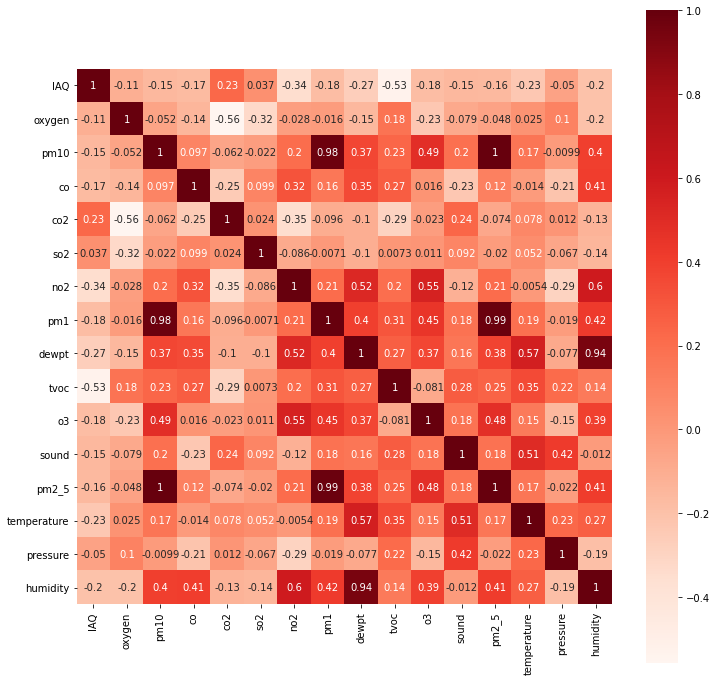

In [40]:
import seaborn as sns
plt.subplots(figsize = (12,12))
sns.heatmap(d,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

In [41]:
data.drop('IAQ', axis=1, inplace=True)
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,,
2023-04-19 11:39:01,20.789,9.315,1.735,507.934,2216.850,21.831,6.452,6.523,0.000,27.653,57.259,7.996,19.024,999.613,45.098
2023-04-19 11:41:03,20.790,9.040,1.730,504.029,2216.820,21.776,6.477,6.466,0.000,27.600,52.367,8.203,19.012,999.632,44.952
2023-04-19 11:43:05,20.789,10.338,1.726,503.302,2216.730,22.191,6.661,6.456,0.000,27.512,52.689,8.830,19.009,999.608,44.932
2023-04-19 11:45:06,20.793,9.173,1.723,503.272,2216.770,23.159,6.771,6.458,0.000,27.481,56.539,8.191,19.012,999.611,44.929
2023-04-19 11:47:08,20.792,8.218,1.720,503.708,2216.800,24.173,5.844,6.435,0.000,27.371,57.535,6.888,19.015,999.604,44.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-02 23:51:16,20.925,1.258,1.500,462.672,130.865,31.681,1.058,8.138,673.009,12.203,53.759,1.253,21.544,995.795,43.095
2023-06-02 23:53:17,20.925,1.608,1.500,460.642,130.676,31.438,0.786,8.145,659.945,12.199,53.738,0.881,21.537,995.800,43.136
2023-06-02 23:55:18,20.925,1.231,1.500,462.282,130.358,31.555,0.930,8.156,665.957,12.191,53.770,0.980,21.535,995.811,43.173


**Multivariate LSTM Predictive Modeling**

In [42]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [43]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [44]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [45]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(28321, 1, 15) (28321, 12) (3146, 1, 15) (3146, 12)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [46]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()



# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(10))
# model.add(Dropout(0.5))
# model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))
# print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/300
394/394 - 1s - loss: 0.0935 - val_loss: 0.0631
Epoch 2/300
394/394 - 1s - loss: 0.0627 - val_loss: 0.0555
Epoch 3/300
394/394 - 1s - loss: 0.0502 - val_loss: 0.0470
Epoch 4/300
394/394 - 1s - loss: 0.0427 - val_loss: 0.0402
Epoch 5/300
394/394 - 1s - loss: 0.0388 - val_loss: 0.0367
Epoch 6/300
394/394 - 1s - loss: 0.0363 - val_loss: 0.0335
Epoch 7/300
394/394 - 1s - loss: 0.0345 - val_loss: 0.0305
Epoch 8/300
394/394 - 1s - loss: 0.0329 - val_loss: 0.0282
Epoch 9/300
394/394 - 1s - loss: 0.0314 - val_loss: 0.0279
Epoch 10/300
394/394 - 1s - loss: 0.0301 - val_loss: 0.0261
Epoch 11/300
394/394 - 1s - loss: 0.0289 - val_loss: 0.0261
Epoch 12/300
394/394 - 1s - loss: 0.0281 - val_loss: 0.0262
Epoch 13/300
394/394 - 1s - loss: 0.0275 - val_loss: 0.0254
Epoch 14/300
394/394 - 1s - loss: 0.0269 - val_loss: 0.0244
Epoch 15/300
394/394 - 1s - loss: 0.0261 - val_loss: 0.0231
Epoch 16/300
394/394 - 1s - loss: 0.0254 - val_loss: 0.0220
Epoch 17/300
394/394 - 1s - loss: 0.0249 - val_lo

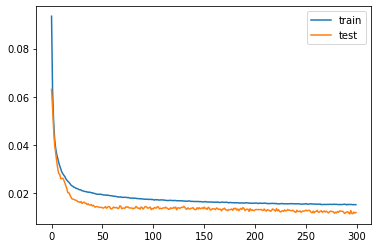

In [47]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

             0         1         2           3           4          5   \
3141  20.928528  1.126059  1.503984  459.935303  137.464371  31.297724   
3142  20.928604  1.236654  1.504056  459.040009  138.328903  31.423836   
3143  20.928644  1.004427  1.503354  457.630737  135.985809  31.093121   
3144  20.928640  1.068228  1.503392  458.781494  137.250610  31.233444   
3145  20.927916  1.030115  1.503512  456.908539  136.564087  31.219664   

            6         7           8          9          10        11  
3141  0.683313  8.177147  648.903564  12.282151  53.388554  0.826082  
3142  0.770384  8.175438  663.382629  12.270452  53.439953  0.932830  
3143  0.589606  8.182315  647.072144  12.242724  53.405182  0.712336  
3144  0.639440  8.190491  653.727417  12.241899  53.444286  0.772457  
3145  0.608408  8.192805  649.935425  12.271789  53.439228  0.736435  
          0      1      2           3           4          5      6      7   \
0  20.922001  2.275  1.572  444.979004  200.869034

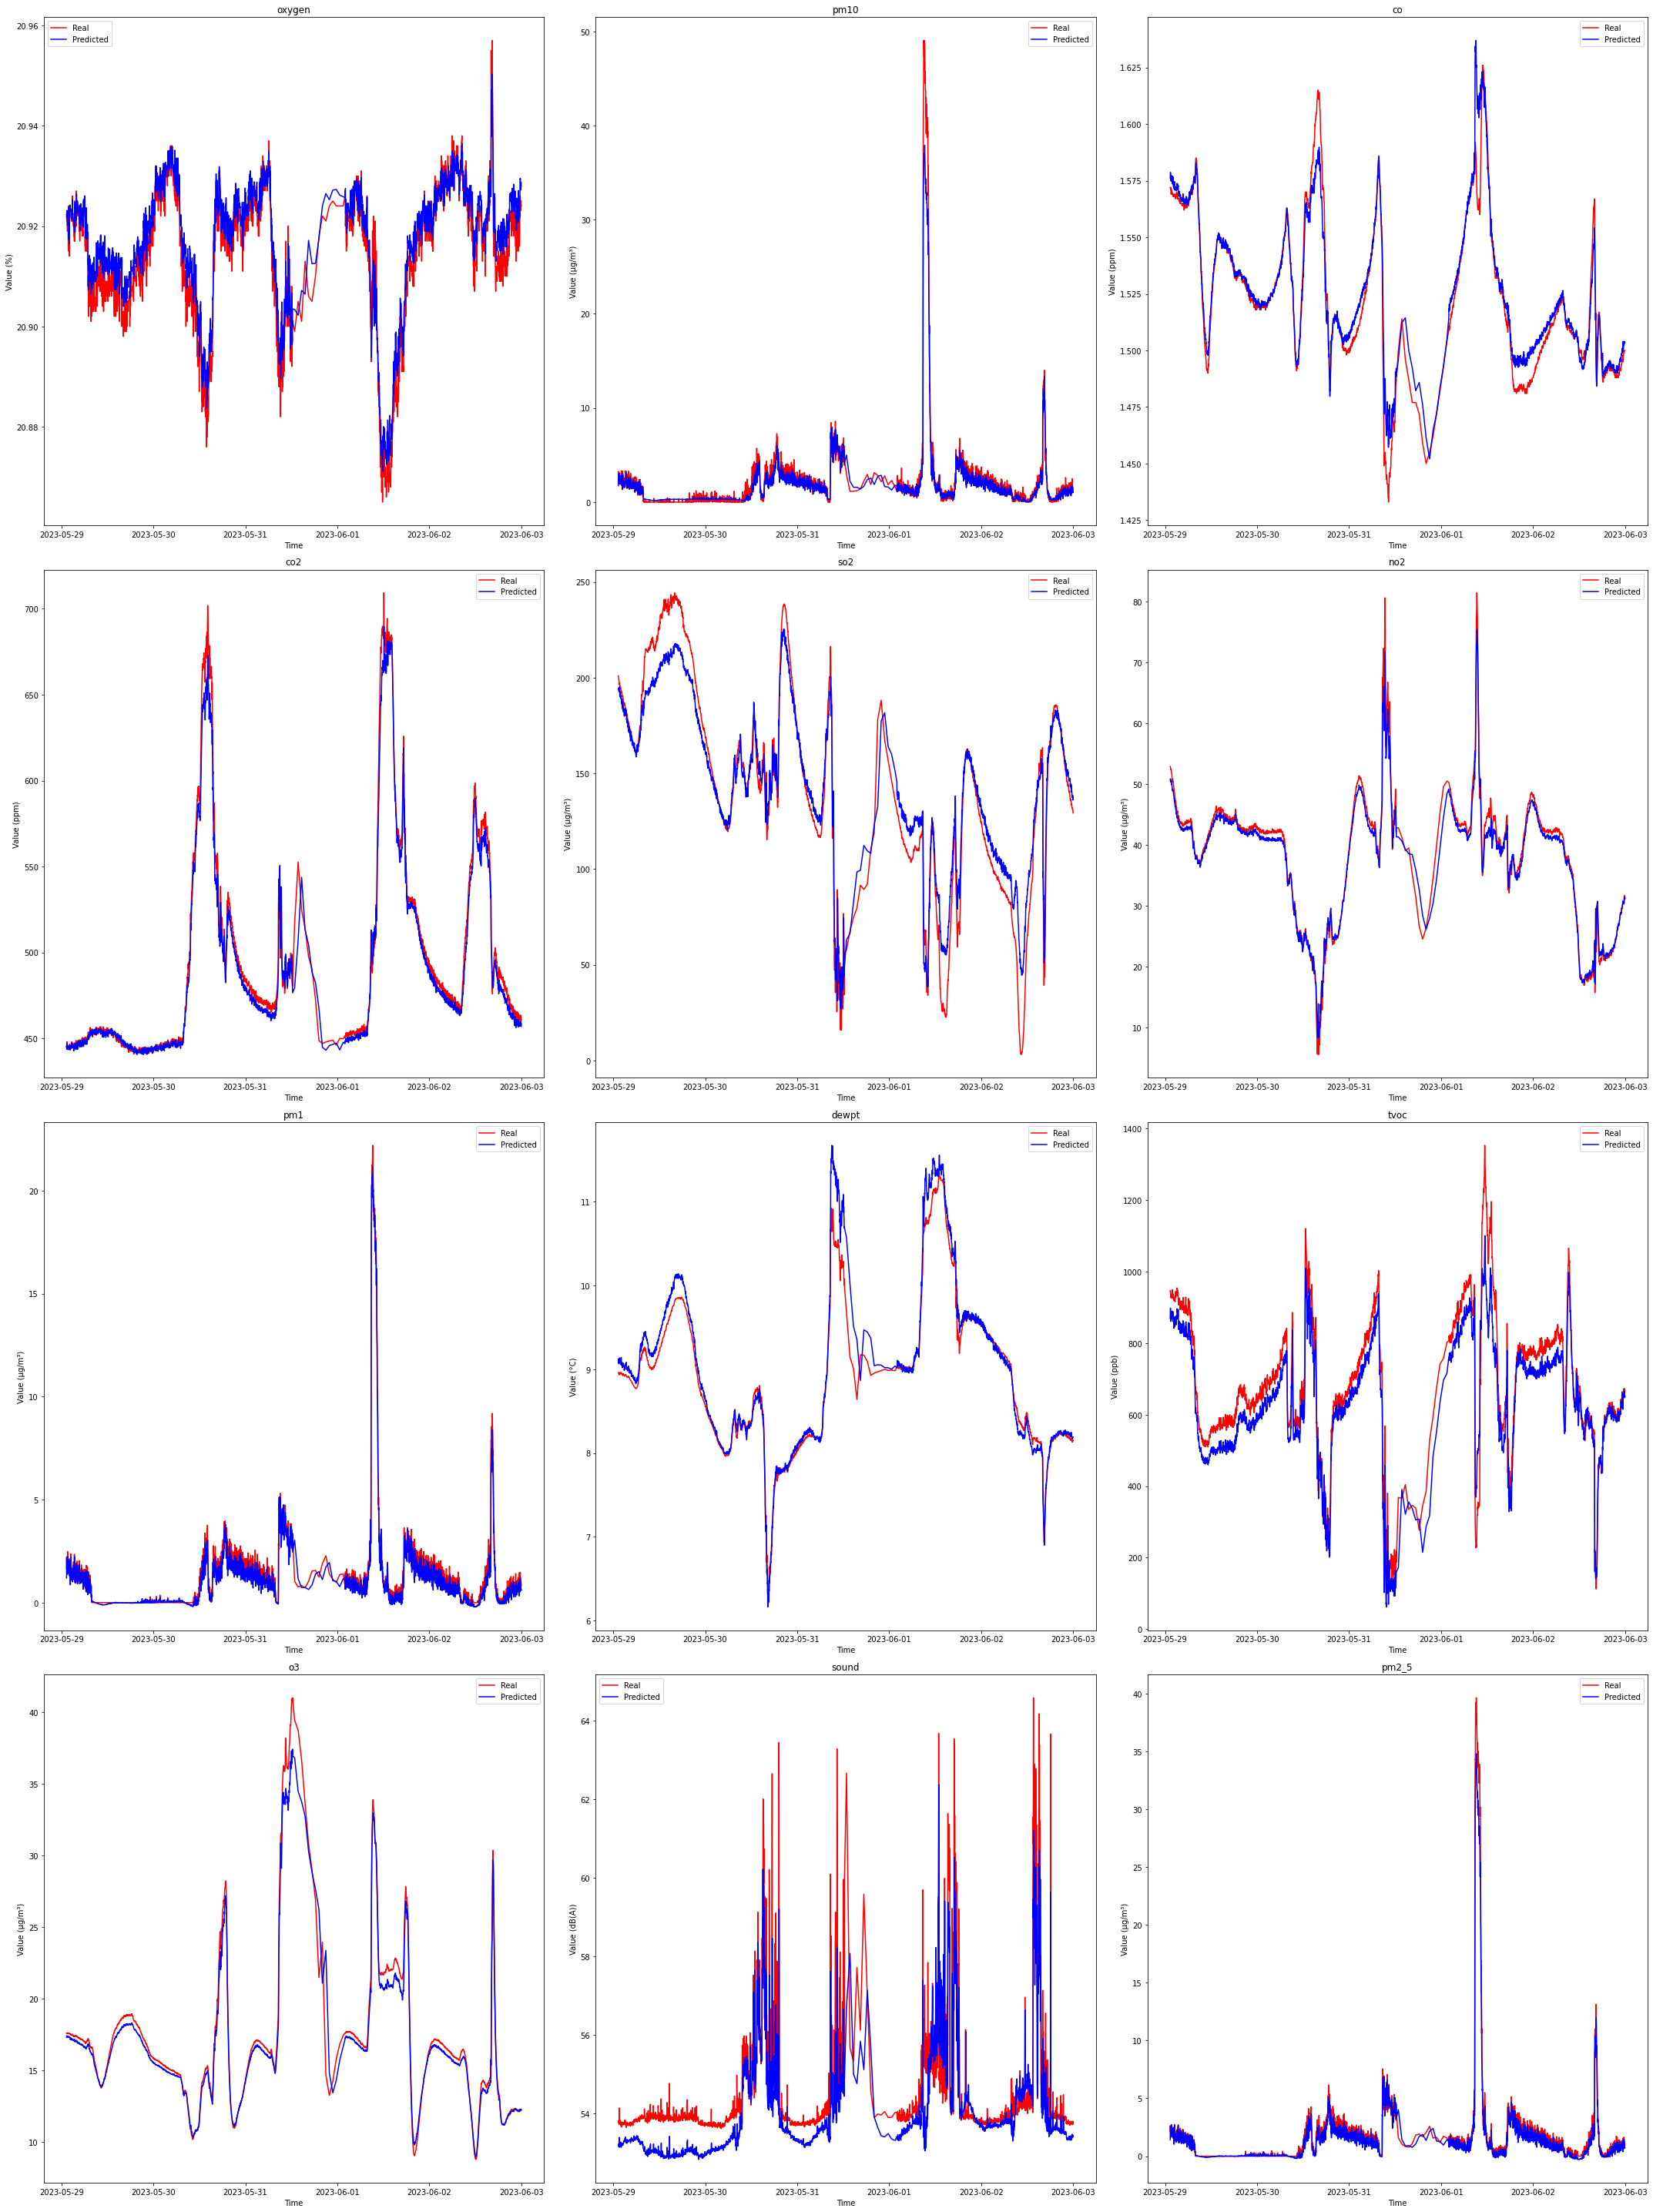

In [48]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [11, 12, 13]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
inv_yhat_df = pd.DataFrame(inv_yhat)
print(inv_yhat_df.tail())

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10,'pm2_5': 11
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m³','sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [49]:
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(3146, 12) (3146, 12)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 1.312
Test RMSE for co: 0.009
Test RMSE for co2: 7.658
Test RMSE for so2: 14.185
Test RMSE for no2: 1.385
Test RMSE for pm1: 0.445
Test RMSE for dewpt: 0.185
Test RMSE for tvoc: 69.405
Test RMSE for o3: 0.724
Test RMSE for sound: 0.964
Test RMSE for pm2_5: 0.815


IAQ

In [50]:
iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [51]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9920534011443103


In [52]:
accuracy_normalized = accuracy_score(inv_y2[:,12], inv_yhat2[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9920534011443103


In [53]:
num_correct = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=False)
print(num_correct) 

3121


anticiper

In [54]:
# 7*2 = 14 min
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [55]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,0.644111,0.216786
8,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,0.429998,0.235852
9,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,0.629902,0.206345
10,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.787097,0.127217,0.995976,0.482153,0.320407,0.303828,0.0,0.655968,0.553239,0.226092
11,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.780645,0.128113,0.995951,0.490854,0.293249,0.299480,0.0,0.651643,0.479335,0.222612
12,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.775806,0.123357,0.995981,0.499776,0.322029,0.295908,0.0,0.646750,0.568265,0.221527
13,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.772581,0.126193,0.996028,0.512571,0.305139,0.297461,0.0,0.641078,0.554329,0.208842
14,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.767742,0.129162,0.996113,0.514346,0.310769,0.293190,0.0,0.636776,0.733109,0.224276
15,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.766129,0.126945,0.996032,0.508239,0.324461,0.287833,0.0,0.631978,0.604245,0.237163
16,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.761290,0.129026,0.996023,0.505100,0.258569,0.283252,0.0,0.627984,0.587720,0.177822


In [56]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 105) (28321, 12) (3140, 105) (3140, 12)


In [57]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(3140, 7, 15) (28321, 7, 15)


In [58]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

# test3
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/300
394/394 - 2s - loss: 0.0819 - val_loss: 0.0594
Epoch 2/300
394/394 - 1s - loss: 0.0573 - val_loss: 0.0565
Epoch 3/300
394/394 - 2s - loss: 0.0480 - val_loss: 0.0472
Epoch 4/300
394/394 - 1s - loss: 0.0411 - val_loss: 0.0408
Epoch 5/300
394/394 - 2s - loss: 0.0376 - val_loss: 0.0356
Epoch 6/300
394/394 - 1s - loss: 0.0359 - val_loss: 0.0338
Epoch 7/300
394/394 - 1s - loss: 0.0349 - val_loss: 0.0308
Epoch 8/300
394/394 - 1s - loss: 0.0333 - val_loss: 0.0282
Epoch 9/300
394/394 - 1s - loss: 0.0318 - val_loss: 0.0272
Epoch 10/300
394/394 - 1s - loss: 0.0300 - val_loss: 0.0278
Epoch 11/300
394/394 - 1s - loss: 0.0287 - val_loss: 0.0280
Epoch 12/300
394/394 - 1s - loss: 0.0278 - val_loss: 0.0278
Epoch 13/300
394/394 - 2s - loss: 0.0267 - val_loss: 0.0265
Epoch 14/300
394/394 - 1s - loss: 0.0264 - val_loss: 0.0272
Epoch 15/300
394/394 - 1s - loss: 0.0260 - val_loss: 0.0264
Epoch 16/300
394/394 - 1s - loss: 0.0257 - val_loss: 0.0288
Epoch 17/300
394/394 - 1s - loss: 0.0254 - val_lo

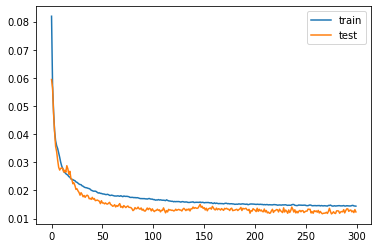

In [59]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

          0      1      2           3           4          5      6      7   \
0  20.919001  2.035  1.570  445.571014  197.987000  52.342999  1.433  8.938   
1  20.919001  1.995  1.569  444.832001  196.900986  52.308998  1.706  8.936   
2  20.919001  2.609  1.570  444.222992  196.459000  52.328003  2.481  8.949   
3  20.919001  2.462  1.570  443.811005  197.253998  52.031002  2.064  8.961   
4  20.920000  1.877  1.570  444.075989  196.863007  51.806999  1.677  8.963   

           8          9          10     11  
0  933.833984  17.576000  53.719002  1.876  
1  930.737000  17.565998  54.139000  1.980  
2  928.432983  17.568001  53.848000  2.607  
3  929.002991  17.548998  53.737000  2.462  
4  931.614014  17.556997  53.770000  1.787  


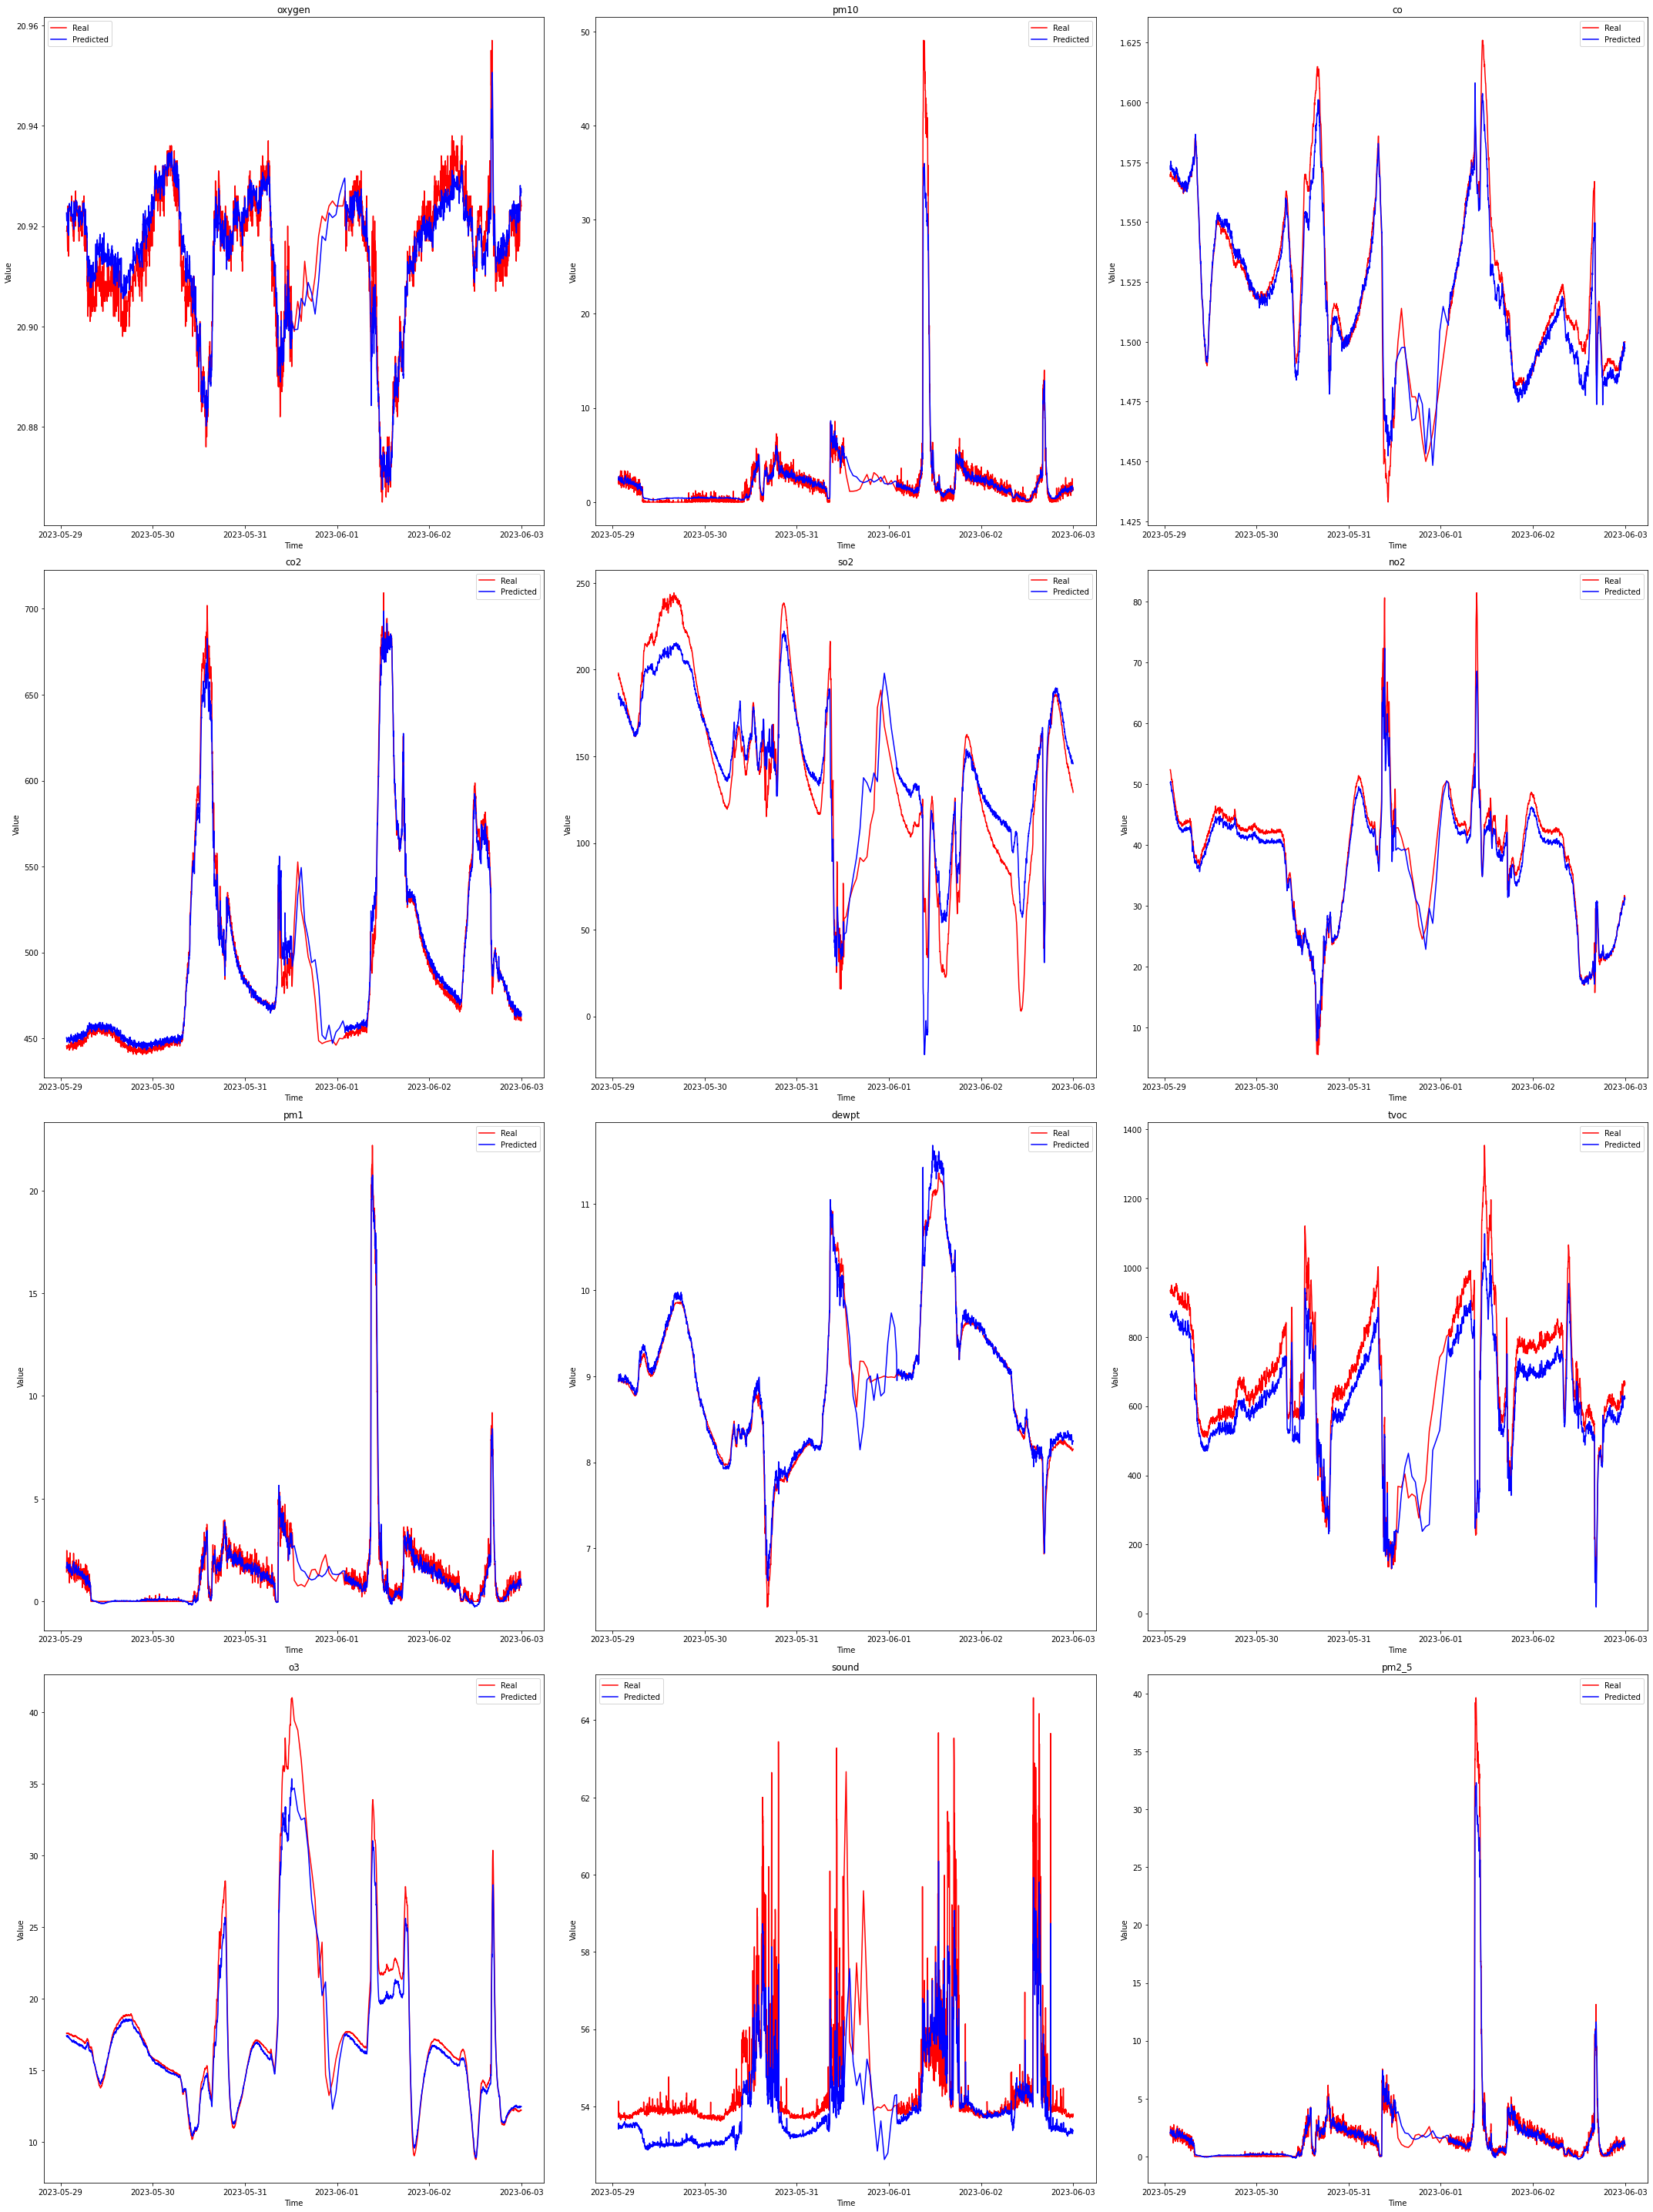

In [60]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# inv_y = inv_y[:, selected_columns]
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 
    'sound': 10, 'pm2_5': 11
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m³','sound': 'dB(A)', 'pm2_5': 'µg/m³'
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [61]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(3140, 12) (3140, 12)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 1.408
Test RMSE for co: 0.008
Test RMSE for co2: 6.882
Test RMSE for so2: 19.437
Test RMSE for no2: 1.883
Test RMSE for pm1: 0.436
Test RMSE for dewpt: 0.111
Test RMSE for tvoc: 74.268
Test RMSE for o3: 1.154
Test RMSE for sound: 1.029
Test RMSE for pm2_5: 0.920


In [62]:
iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [63]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9929936305732484


In [64]:
accuracy_normalized = accuracy_score(inv_y2[:,12], inv_yhat2[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9929936305732484


In [65]:
num_correct = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=False)
print(num_correct) 

3118
